<a href="https://colab.research.google.com/github/LeenShaikh/AskPy/blob/main/AskPy_Agentic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 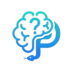**AskPy**


In [4]:
!pip install -q \
  streamlit \
  sentence-transformers \
  faiss-cpu \
  transformers \
  langfuse \
  pyngrok \
  fastapi \
  uvicorn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.8/413.8 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 8.0 MB/s eta 0:00:00


In [14]:
!pip install opentelemetry-api==1.37.0 opentelemetry-sdk==1.37.0 -q
!pip install fastmcp --no-deps -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.9/131.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.0/208.0 kB 9.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-exporter-prometheus 0.60b1 requires opentelemetry-sdk~=1.39.1, but you have opentelemetry-sdk 1.37.0 which is incompatible.
opentelemetry-instrumentation 0.60b1 requires opentelemetry-semantic-conventions==0.60b1, but you have opentelemetry-semantic-conventions 0.58b0 which is incompatible.


In [3]:
!pip install --upgrade google-genai -q

## Setting up ngrok and Langfuse keys securely
- `ngrok token`: Create a public link for the Streamlit app.
- `Langfuse API keys`: Connect securely to Langfuse for observability.

In [1]:
from getpass import getpass
import os

#token = getpass("Enter your ngrok token: ")
#ngrok.set_auth_token(token)
secret_key = getpass("Enter your Langfuse Secret Key: ")
public_key = getpass("Enter your Langfuse Public Key: ")

os.environ["LANGFUSE_SECRET_KEY"] = secret_key
os.environ["LANGFUSE_PUBLIC_KEY"] = public_key
os.environ["LANGFUSE_BASE_URL"] = "https://cloud.langfuse.com"

Enter your Langfuse Secret Key: ··········
Enter your Langfuse Public Key: ··········


In [2]:
from getpass import getpass
import os

# Gemini API key
os.environ["GOOGLE_API_KEY"] = getpass("Enter your Gemini API Key from AI Studio: ")

Enter your Gemini API Key from AI Studio: ··········


## Uploading Data from Google Drive
- `data_py.json` : The documents used for RAG retrieval.
- `icon.png` : Application icon.
- `trans.png` : Transparent image used as chat avatar placeholder.

In [5]:
from google.colab import drive
import json
import os
from PIL import Image

drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/AskPy2/data_py.json"
icon_path = "/content/drive/MyDrive/AskPy2/icon.png"
trans_path = "/content/drive/MyDrive/AskPy2/trans.png"

with open(file_path, "r", encoding="utf-8") as f:
    dataset = json.load(f)

# Resize the transparent image to 1x1 pixels to ensure it functions as just empty space.

img = Image.open(trans_path)
img = img.resize((1, 1), Image.Resampling.LANCZOS)
img.save(trans_path)

# Verify the number of documents uploaded

print(f"Loaded {len(dataset)} documents")


Mounted at /content/drive
Loaded 245 documents


In [3]:
%%writefile rag_tool.py

import json
import numpy as np
from sentence_transformers import SentenceTransformer
import faiss
import os
import google.genai as genai


# ---------------------- Load Docs ----------------------
def load_docs(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        raw = json.load(f)
    docs = []
    for d in raw:
        title = d.get("title", "")
        content = d.get("content", "")
        examples = d.get("example", "")
        if isinstance(examples, list):
            examples_text = "\n".join(examples)
        elif isinstance(examples, str):
            examples_text = examples
        else:
            examples_text = ""
        full = f"{title}\n\n{content}"
        if examples_text:
            full += f"\n\nExamples:\n{examples_text}"
        docs.append(full)
    return docs

# ---------------------- Embeddings + Index ----------------------
def load_embedder():
    return SentenceTransformer("all-MiniLM-L6-v2")

def build_index(docs, embedder):
    vecs = embedder.encode(docs, convert_to_numpy=True)
    vecs = vecs / np.linalg.norm(vecs, axis=1, keepdims=True)
    index = faiss.IndexFlatIP(vecs.shape[1])
    index.add(vecs)
    return vecs, index

def search_docs(query, embedder, vectors, index, k=2):
    qvec = embedder.encode([query], convert_to_numpy=True)
    qvec = qvec / np.linalg.norm(qvec)
    _, ids = index.search(qvec.reshape(1, -1), k)
    return ids[0]

# ---------------------- LLM using Gemini ----------------------
def load_llm():
    api_key = os.environ.get("GOOGLE_API_KEY")
    if not api_key:
        raise ValueError("Gemini API key not found in environment variable GOOGLE_API_KEY")
    client = genai.Client(api_key=api_key)

    def pipe(prompt):
        response = client.models.generate_content(
            model="models/gemini-2.5-flash",
            contents=prompt
        )
        return [{"generated_text": response.text}]

    return pipe

def generate_answer(context, user_question, pipe):
    prompt = f"""
Use the context below to answer the question.
If the answer is contained in the context, use only that information.
If the answer is not in the context, generate a clear, concise answer in 1-3 sentences, with at most one example if helpful.

Context:
{context}

Question:
{user_question}

Answer:
"""
    return pipe(prompt)[0]["generated_text"].strip()



def askpy_rag_tool(question: str) -> str:
    file_path = "/content/drive/MyDrive/AskPy2/data_py.json"
    docs = load_docs(file_path)
    embedder = load_embedder()
    vectors, index = build_index(docs, embedder)
    pipe = load_llm()

    ids = search_docs(question, embedder, vectors, index, k=2)
    context = "\n\n---\n\n".join(docs[i] for i in ids)

    answer = generate_answer(context, question, pipe)

    return answer




Overwriting rag_tool.py


In [4]:
%%writefile agent_adk.py
from google.adk.agents import Agent
from google.adk.tools import FunctionTool
from rag_tool import askpy_rag_tool

answer_tool = FunctionTool(func=askpy_rag_tool)

agent = Agent(
    name="AskPyAgent",
    model="gemini-2.5-flash",
    instruction="You answer user questions using the RAG tool",
    tools=[answer_tool]
)

if __name__ == "__main__":
    question = input("write your question: ")
    answer = askpy_rag_tool(question)
    print("answer", answer)


Overwriting agent_adk.py


In [5]:
%%writefile mcp_server.py

from fastmcp import FastMCP
from rag_tool import askpy_rag_tool

mcp = FastMCP("AskPy MCP Server")

@mcp.tool(
    name="ask_python",
    description="Answer Python questions using a RAG-based knowledge base"
)
def ask_python(question: str) -> str:
    """
    This tool takes a Python-related question and returns an answer
    using Retrieval-Augmented Generation (RAG).
    """
    return askpy_rag_tool(question)


if __name__ == "__main__":
    mcp.run()


Overwriting mcp_server.py


In [6]:
%%writefile app.py
import streamlit as st
import os
from langfuse import Langfuse
from rag_tool import askpy_rag_tool

# ---------------------- Langfuse ----------------------
langfuse = Langfuse(
    public_key=os.environ["LANGFUSE_PUBLIC_KEY"],
    secret_key=os.environ["LANGFUSE_SECRET_KEY"],
    host=os.environ["LANGFUSE_BASE_URL"]
)

# ---------------------- Paths ----------------------
icon_path = "/content/drive/MyDrive/AskPy2/icon.png"
trans_path = "/content/drive/MyDrive/AskPy2/trans.png"

# ---------------------- Streamlit Page Config ----------------------
st.set_page_config(
    page_title="AskPy - Agentic Python Tutor",
    layout="centered",
    page_icon=icon_path
)

# ---------------------- Header ----------------------
col1, col2 = st.columns([1, 8])
with col1:
    st.image(icon_path, width=100)
with col2:
    st.markdown("# AskPy — Agentic Python AI Tutor")
    st.caption("RAG-powered • Gemini • MCP-ready")

# ---------------------- Chat State ----------------------
if "messages" not in st.session_state:
    st.session_state.messages = []

# Display previous messages
for role, msg in st.session_state.messages:
    if role == "user":
        st.chat_message("user", avatar=trans_path).markdown(msg)
    else:
        st.chat_message("assistant", avatar=icon_path).markdown(msg)

# ---------------------- Chat Input ----------------------
query = st.chat_input("Ask a Python question...")

if query:
    # show user message
    st.session_state.messages.append(("user", query))
    st.chat_message("user", avatar=trans_path).markdown(query)

    with st.chat_message("assistant", avatar=icon_path):
        placeholder = st.empty()
        with st.spinner("Thinking..."):

            # Root observation
            with langfuse.start_as_current_observation(
                as_type="span",
                name="AskPy User Question"
            ):

                # Retrieval + Generation combined inside RAG tool
                with langfuse.start_as_current_observation(
                    as_type="generation",
                    name="RAG + Gemini Generation"
                ) as span:

                    answer = askpy_rag_tool(query)

                    span.update(
                        input=query,
                        output=answer,
                        metadata={
                            "model": "gemini-2.5-flash",
                            "pipeline": "RAG",
                            "agentic": True
                        }
                    )

            placeholder.markdown(answer)

    st.session_state.messages.append(("assistant", answer))


Writing app.py


In [7]:
!python mcp_server.py

2025-12-24 14:26:25.421639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766586385.443984    7939 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766586385.450527    7939 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766586385.467806    7939 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766586385.467850    7939 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766586385.467854    7939 computation_placer.cc:177] computation placer alr

In [3]:
%%writefile .gitignore
*.gdoc
*.gsheet
*.gslides
*.ipynb_checkpoints/
drive/
__pycache__/

Writing .gitignore


In [8]:
!streamlit run app.py





Aborted!
Exception ignored in: <module 'threading' from '/usr/lib/python3.12/threading.py'>
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1575, in _shutdown
    def _shutdown():
    
KeyboardInterrupt: 
^C


## Running and Connecting the Streamlit App to ngrok
- Run Streamlit app on port 8501
- Restart ngrok to avoid pending sessions
- Generate a public URL to access the app from outside Colab

In [ ]:
!streamlit run app.py --server.port 8501 > /content/log.txt 2>&1 &
from pyngrok import ngrok
ngrok.kill()
public_url = ngrok.connect(8501)
public_url

<NgrokTunnel: "https://293c211ecdad.ngrok-free.app" -> "http://localhost:8501">

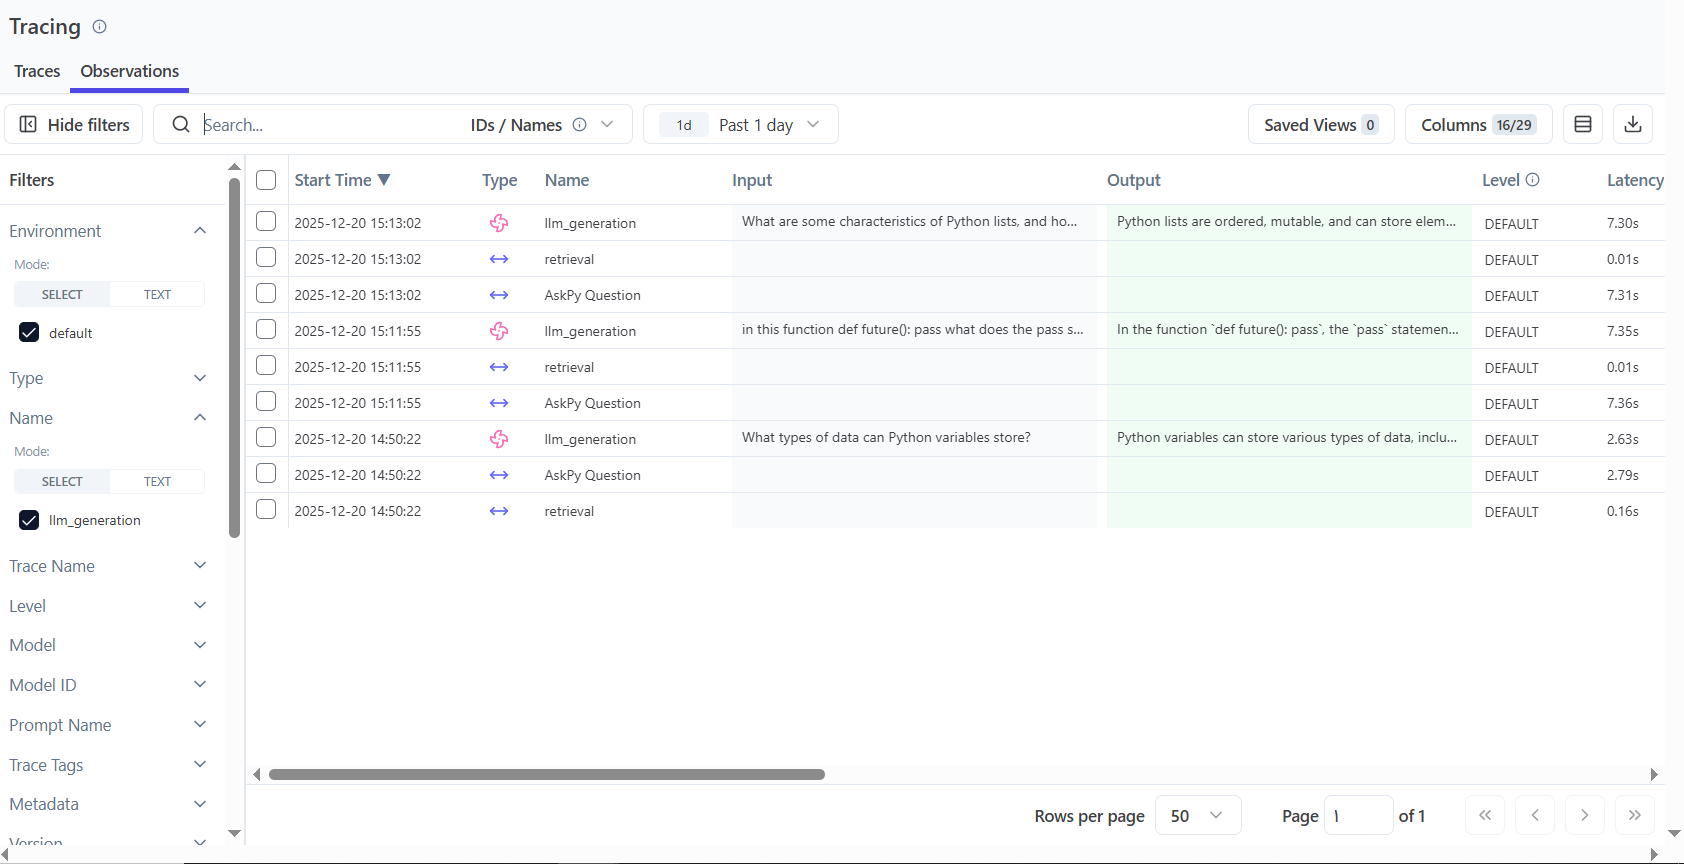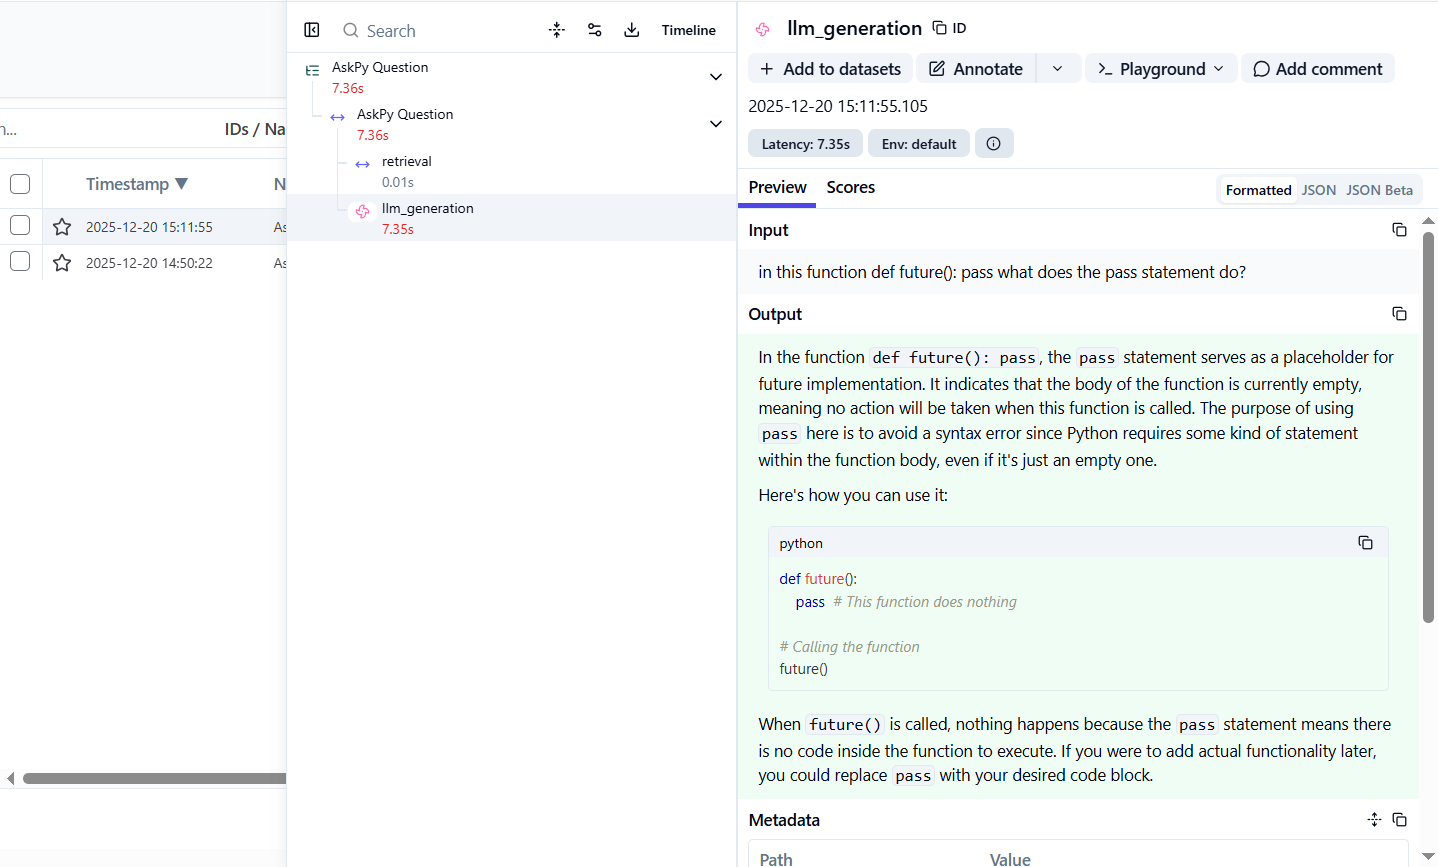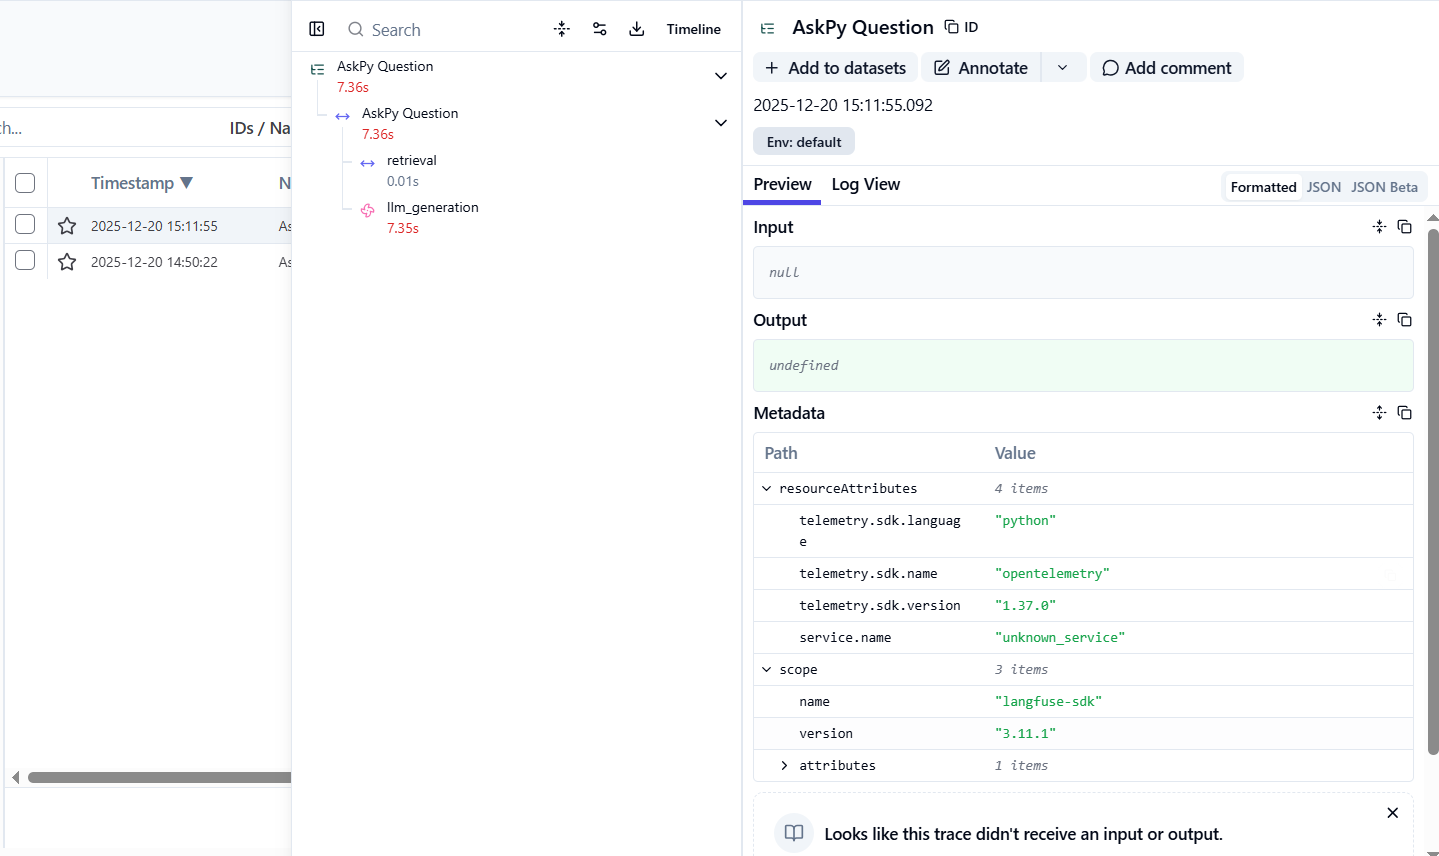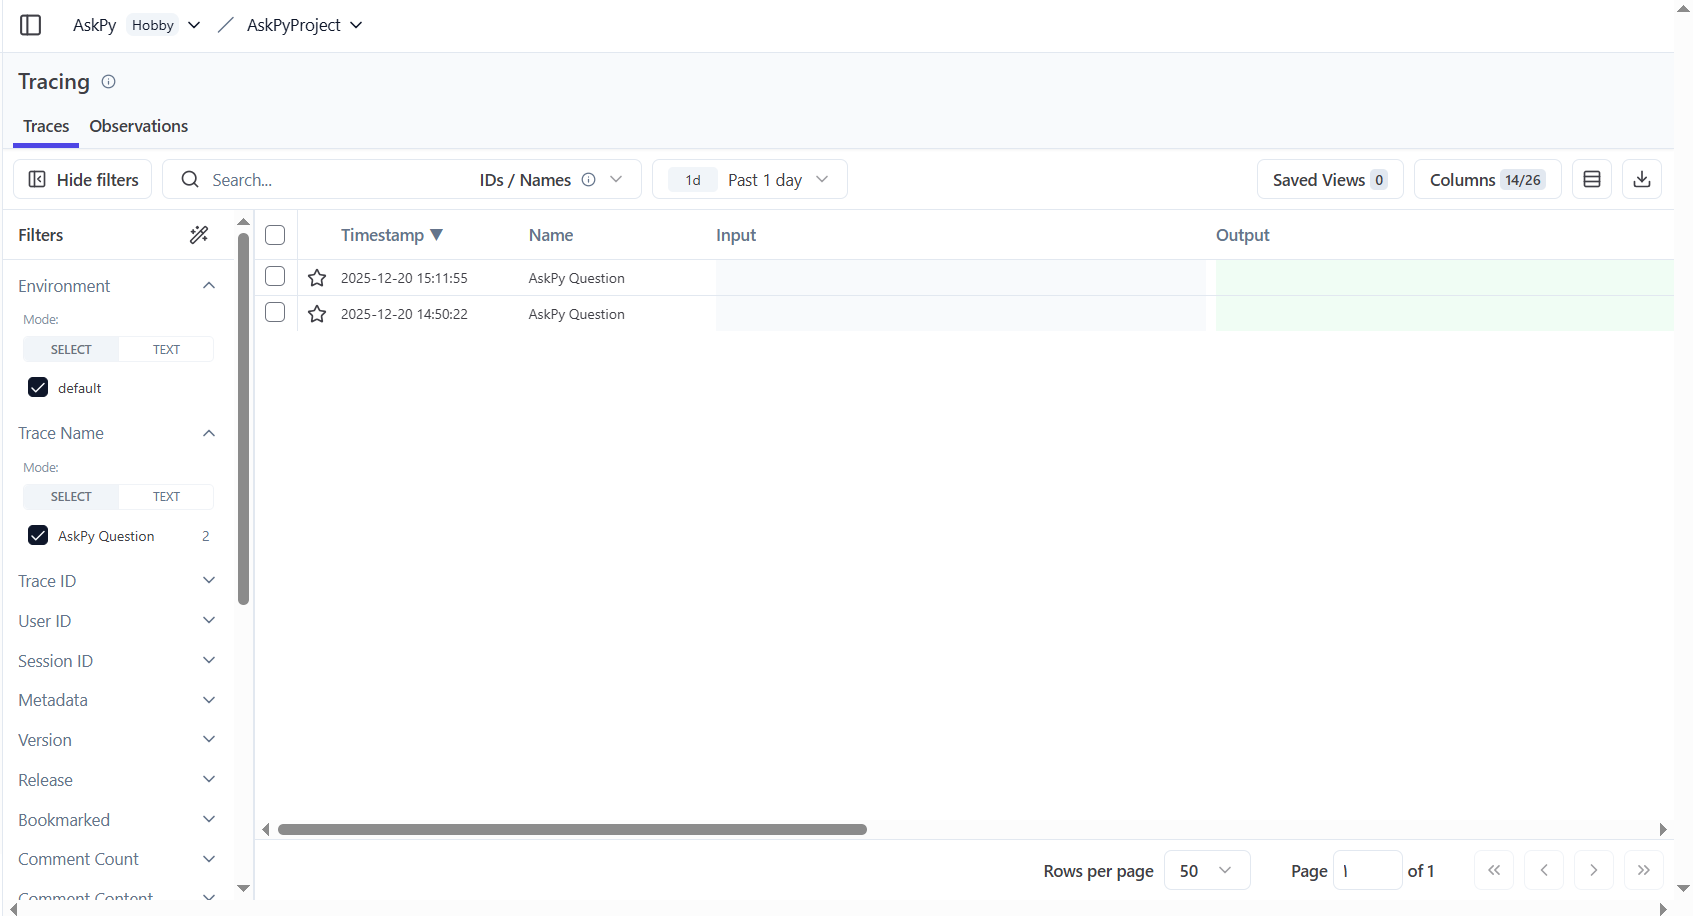

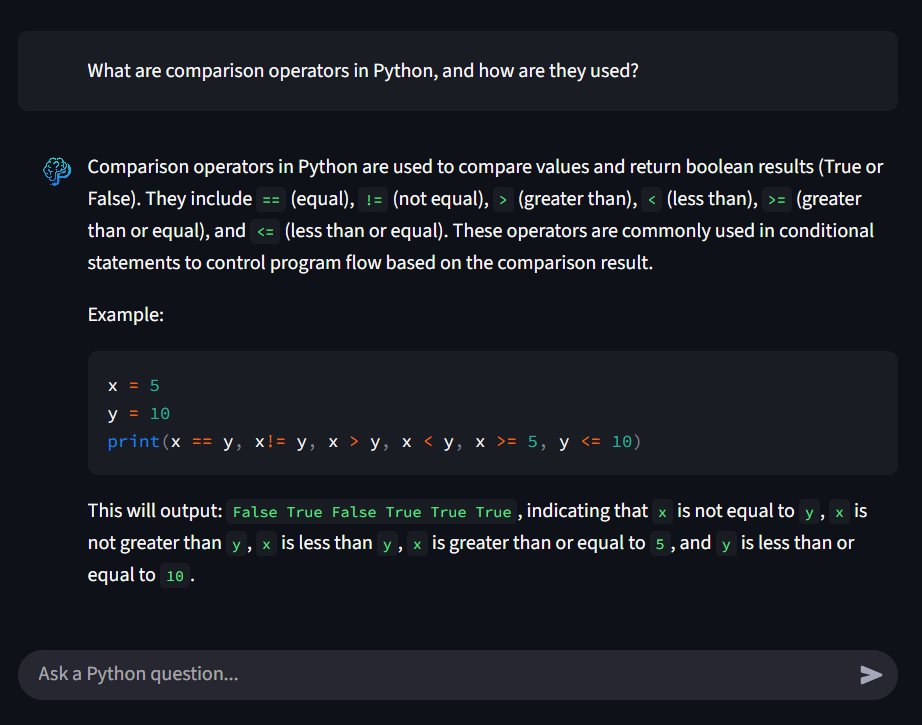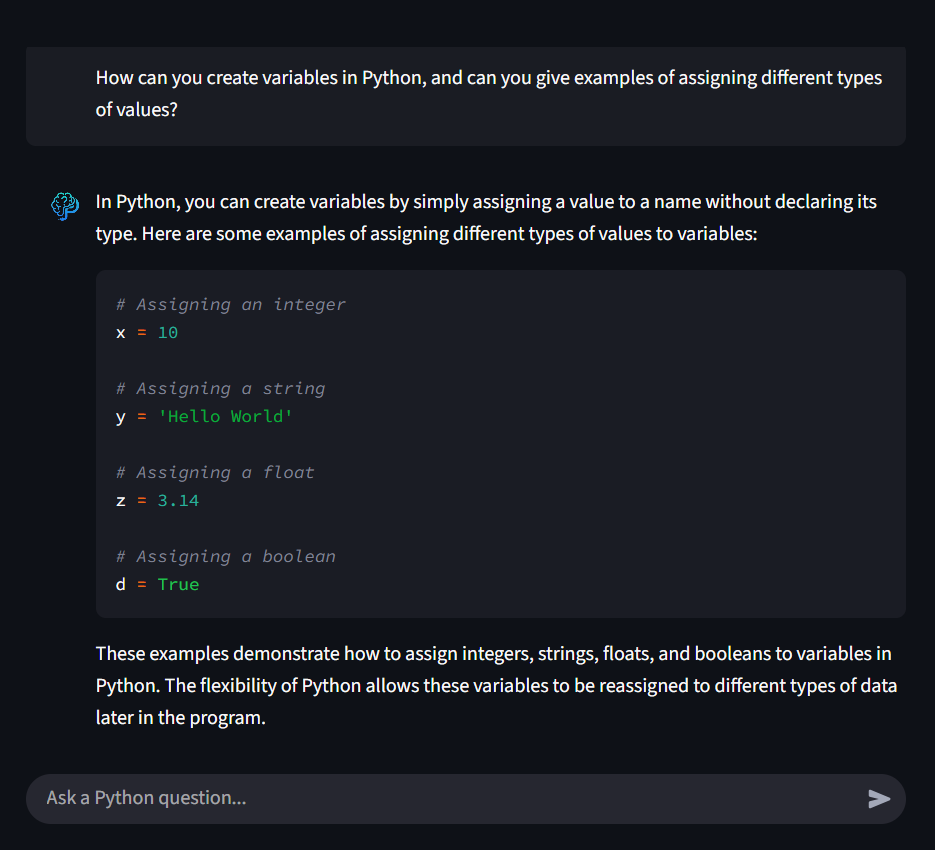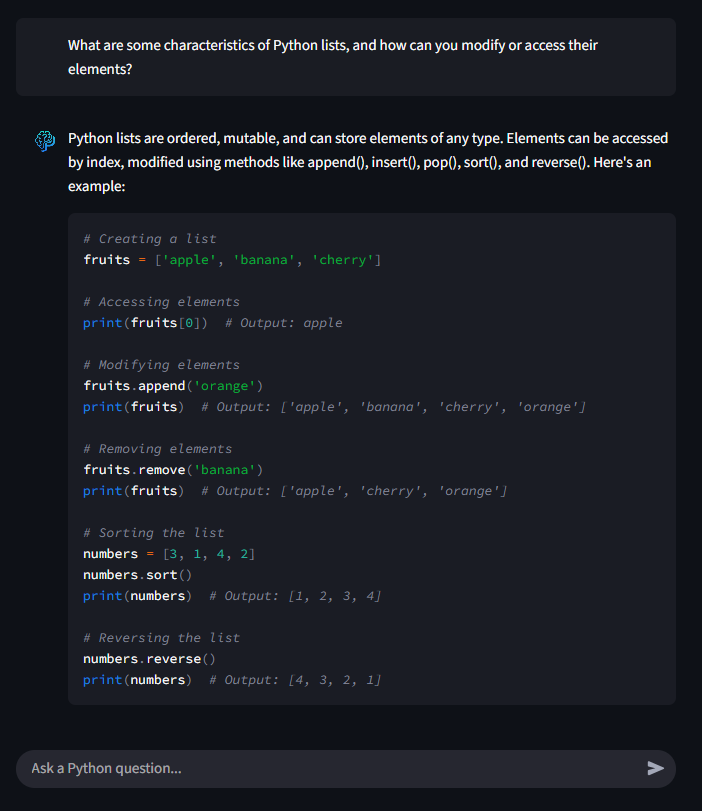